# Understanding The Problem

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

# Understanding the Dataset


The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded


In [85]:
# Importing the Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc  #for deleting unused variables

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv("train_sample.csv")
df.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [5]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [8]:
# check the unique values

def unique_val(x):
    return len(df[x].unique())

unique_val_num = {x: unique_val(x) for x in df.columns}
unique_val_num

{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'attributed_time': 228,
 'is_attributed': 2}

In [9]:
df.isna().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [17]:
# "attributed_time" columns is full of missing value..It would be better to drop the column..

# creating a copy dataset
new_df = df.copy()
new_df.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [18]:
new_df.drop(["attributed_time"],axis = 1,inplace = True)

In [19]:
new_df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

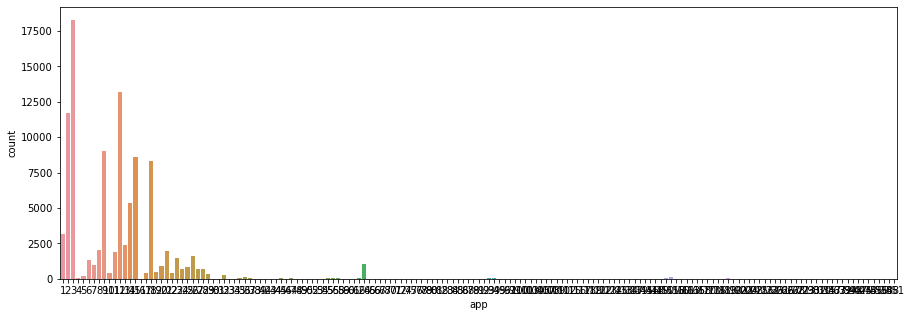

In [28]:
# distribution of "app"
plt.figure(figsize = (15,5))
sns.countplot(x= "app",data = new_df)

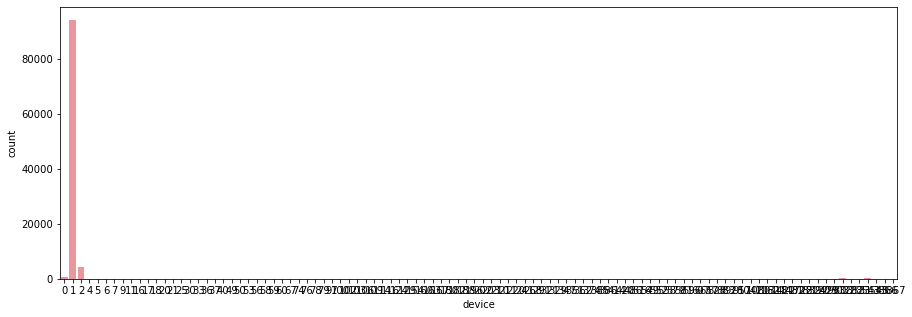

In [30]:
# Distribution of "Device"
plt.figure(figsize = (15,5))
sns.countplot(x = "device",data = new_df)

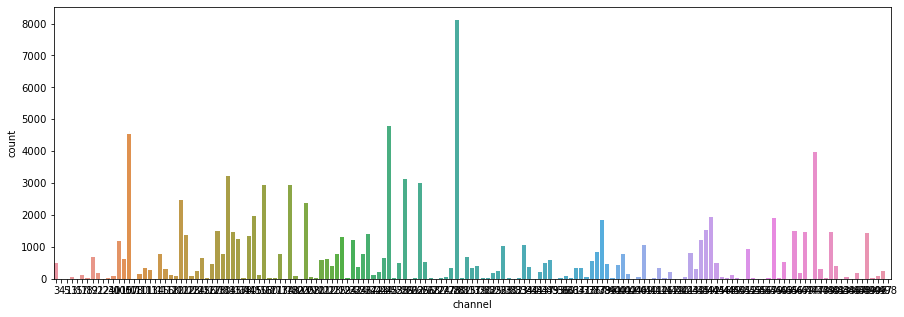

In [31]:
# Channel distribution
plt.figure(figsize = (15,5))
sns.countplot(x = "channel",data = new_df)

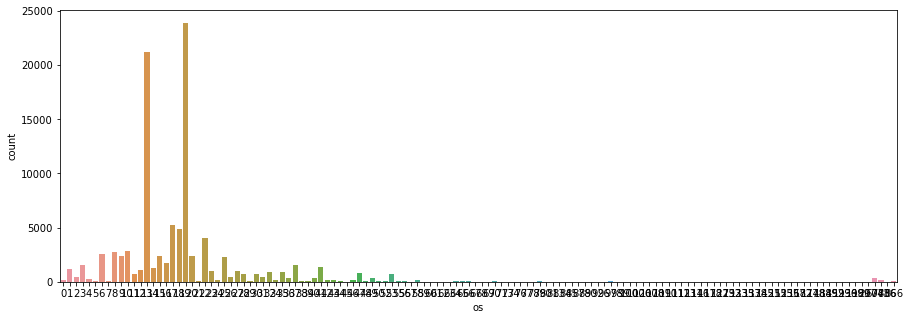

In [32]:
# OS 
plt.figure(figsize = (15,5))
sns.countplot(x = "os",data = new_df)

In [35]:
# Now look at the target variable distribution "Is_attributed"

(new_df["is_attributed"].astype('object').value_counts()/len(new_df.index))*100

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only about **0.2% clicks** are **'Frudulent**.This is such an highly class imblance problem

# Exploring the Data


In [37]:
app_target = new_df.groupby("app").is_attributed.agg(["mean","count"])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


Lets get rid of  the apps that are very rare(say which comprise of less than 20% clicks) and plot this.

In [40]:
frequent_apps = new_df.groupby("app").size().reset_index(name = "count")
frequent_apps = frequent_apps[frequent_apps["count"]>frequent_apps["count"].quantile(0.80)]
frequent_apps = frequent_apps.merge(new_df,on = "app",how = "inner")
frequent_apps.head(4)

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0


In [42]:
frequent_apps.shape

(98977, 8)

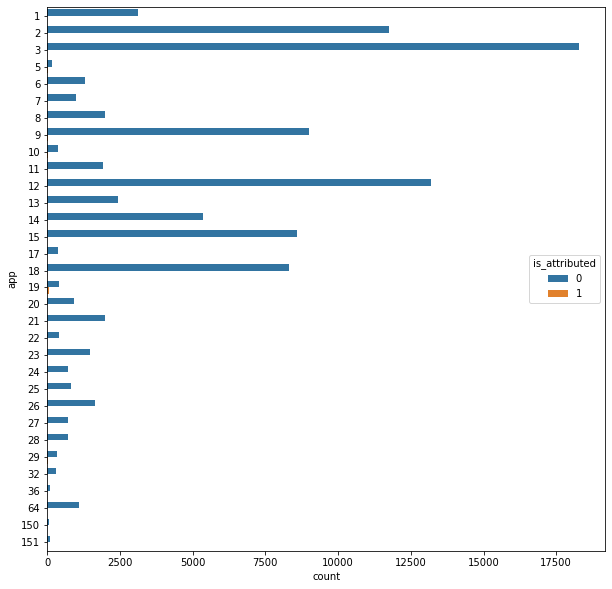

In [44]:
plt.figure(figsize = (10,10))
sns.countplot(y = "app",hue = "is_attributed",data = frequent_apps)

# Feature Engineering

Lets derive some new features from existing dataset

In [48]:
def time_feature(dff):
    dff["datetime"] = pd.to_datetime(dff["click_time"])
    dff["day_of_week"] = dff["datetime"].dt.dayofweek
    dff["day_of_year"] = dff["datetime"].dt.dayofweek
    dff["month"] = dff["datetime"].dt.month
    dff["hour"] = dff["datetime"].dt.hour
    
    return dff

In [50]:
#creating new datetime variables and drop the old one

new_df = time_feature(new_df)
new_df.drop(["datetime","click_time"],axis = 1,inplace = True)
new_df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,1,11,9
1,105560,25,1,17,259,0,1,1,11,13
2,101424,12,1,19,212,0,1,1,11,18
3,94584,13,1,13,477,0,1,1,11,4
4,68413,12,1,1,178,0,3,3,11,9


In [52]:
df.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [53]:
new_df.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

In [56]:
# memory used by training dataset

print(f"memory used by training dataset: {(new_df.memory_usage().sum())/1024**2 }MB")

memory used by training dataset: 7.6295166015625MB


In [57]:
#Lets convert the variables back to lower dtype again
int_vars = ["ip","app","device","os","channel","day_of_week","day_of_year","month","hour","is_attributed"]
new_df[int_vars] = new_df[int_vars].astype("uint16")

In [58]:
new_df.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint16
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [60]:
# memory used by training dataset

print(f"Memory used by training dataset: {(new_df.memory_usage().sum())/1024**2 }MB")

Memory used by training dataset: 1.907470703125MB


In [75]:
# Grouping ip based feature

ip_count = new_df.groupby("ip").size().reset_index(name = "ip_count").astype('int16')
ip_count.head(4)

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1


In [70]:
def grouped_features(dff):
    # ip_count
    ip_count = dff.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = dff.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = dff[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = dff.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = dff.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = dff.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    dff = pd.merge(dff, ip_count, on='ip', how='left')
    del ip_count
    dff = pd.merge(dff, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    dff = pd.merge(dff, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    dff = pd.merge(dff, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    dff = pd.merge(dff, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    dff = pd.merge(dff, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return dff

In [76]:
new_df.head(4)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,1,11,9
1,40024,25,1,17,259,0,1,1,11,13
2,35888,12,1,19,212,0,1,1,11,18
3,29048,13,1,13,477,0,1,1,11,4


In [77]:
new_df = grouped_features(new_df)
new_df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,1,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,1,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,1,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,1,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,3,11,9,4,1,1,1,1,1


In [80]:
print(f"Memory used by Training set : {(new_df.memory_usage().sum()/1024**2)}MB")

Memory used by Training set : 3.814697265625MB


In [81]:
# garbage collect (unused) object
gc.collect()

305

# Modeling 

In [82]:
X = new_df.drop(["is_attributed"],axis = 1)
y = new_df["is_attributed"]

#split the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 22)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 15)
(30000, 15)
(70000,)
(30000,)


In [83]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

0.0022
0.0024333333333333334


In [86]:
# build model
model = XGBClassifier()

#fit the data
model.fit(X_train,y_train)

[00:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [87]:
model.score(X_test,y_test)

0.9978

In [88]:
y_pred = model.predict(X_test)

In [96]:
# Model evaluation

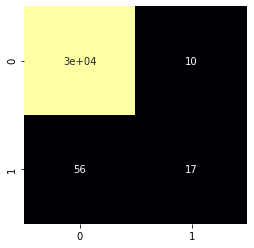

In [94]:
plt.figure(figsize = (4,4))
sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True,
            cmap = "inferno",
            cbar = False)

In [95]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc

y_pred_prob = model.predict_proba(X_test)
y_pred_prob[:10]

array([[9.9999046e-01, 9.5184932e-06],
       [9.9997759e-01, 2.2413304e-05],
       [9.9984121e-01, 1.5879663e-04],
       [9.9999499e-01, 5.0320145e-06],
       [9.9997038e-01, 2.9623348e-05],
       [9.9993813e-01, 6.1852115e-05],
       [9.9991572e-01, 8.4262785e-05],
       [9.9999923e-01, 7.4593521e-07],
       [9.9995941e-01, 4.0596278e-05],
       [9.9990338e-01, 9.6604730e-05]], dtype=float32)

In [100]:
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc_score(y_test,y_pred_prob[:,1])

0.9720987736826276

In [106]:
fpr,tpr,threshold = roc_curve(y_test,y_pred_prob[:,1])

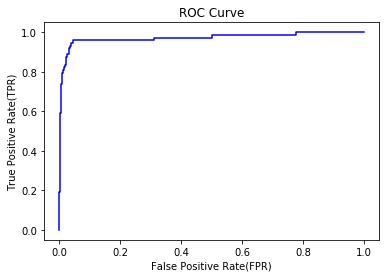

In [107]:
plt.plot(fpr,tpr,color = "blue",label = "ROC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.show()

# Hyperparameter Tuning

In [122]:
param_grid = {"learning_rate":[0.2,0.5],
              "subsample":[0.3,0.6,0.9],
              "gamma":[0,1]}

xgb_model = XGBClassifier(max_depth = 3,n_estimators = 200,eval_metric= 'logloss')

#cv model
cv_model = GridSearchCV(xgb_model,
                        param_grid = param_grid,
                        cv = 3,
                        scoring = "roc_auc",
                        return_train_score = True,
                        verbose = 1
                        )

In [123]:
#Fit the model

cv_model.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_const...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
  

In [125]:
#cv results
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.727407,0.326034,0.077048,1.683477e-02,0,0.2,0.3,"{'gamma': 0, 'learning_rate': 0.2, 'subsample'...",0.922363,0.946287,0.953302,0.940651,0.013245,7,0.995264,0.997735,0.996450,0.996483,1.008999e-03
1,4.986260,0.671016,0.053132,5.939020e-03,0,0.2,0.6,"{'gamma': 0, 'learning_rate': 0.2, 'subsample'...",0.942993,0.956567,0.934460,0.944673,0.009103,4,0.998798,0.999259,0.998897,0.998985,1.982329e-04
2,4.146633,0.124831,0.049305,4.705838e-04,0,0.2,0.9,"{'gamma': 0, 'learning_rate': 0.2, 'subsample'...",0.948786,0.960511,0.940776,0.950024,0.008104,1,0.999025,0.999207,0.998639,0.998957,2.368641e-04
3,3.904820,0.142698,0.049574,4.125874e-03,0,0.5,0.3,"{'gamma': 0, 'learning_rate': 0.5, 'subsample'...",0.909481,0.935613,0.935925,0.927006,0.012393,11,0.999417,0.998532,0.999328,0.999093,3.978929e-04
4,4.353503,0.036119,0.051214,1.721109e-03,0,0.5,0.6,"{'gamma': 0, 'learning_rate': 0.5, 'subsample'...",0.934103,0.945398,0.939192,0.939564,0.004619,8,1.000000,0.999998,0.999994,0.999997,2.323872e-06
5,4.093611,0.063067,0.047876,2.109778e-03,0,0.5,0.9,"{'gamma': 0, 'learning_rate': 0.5, 'subsample'...",0.940579,0.936757,0.946054,0.941130,0.003815,6,1.000000,1.000000,1.000000,1.000000,9.877463e-08
6,3.823405,0.033556,0.049997,5.150430e-07,1,0.2,0.3,"{'gamma': 1, 'learning_rate': 0.2, 'subsample'...",0.927645,0.945624,0.941218,0.938163,0.007651,10,0.994452,0.996986,0.991224,0.994221,2.358258e-03
7,4.324211,0.017494,0.048399,2.637142e-03,1,0.2,0.6,"{'gamma': 1, 'learning_rate': 0.2, 'subsample'...",0.942713,0.962911,0.934924,0.946849,0.011794,3,0.998898,0.998908,0.998505,0.998770,1.875657e-04
8,4.046580,0.009978,0.091660,2.356852e-03,1,0.2,0.9,"{'gamma': 1, 'learning_rate': 0.2, 'subsample'...",0.946092,0.959953,0.939630,0.948558,0.008478,2,0.998115,0.998816,0.997526,0.998152,5.272111e-04
9,3.778596,0.004858,0.049997,6.836514e-07,1,0.5,0.3,"{'gamma': 1, 'learning_rate': 0.5, 'subsample'...",0.913304,0.934410,0.911189,0.919635,0.010484,12,0.999034,0.998771,0.995518,0.997774,1.598892e-03


In [131]:
#convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
#cv_results.head()


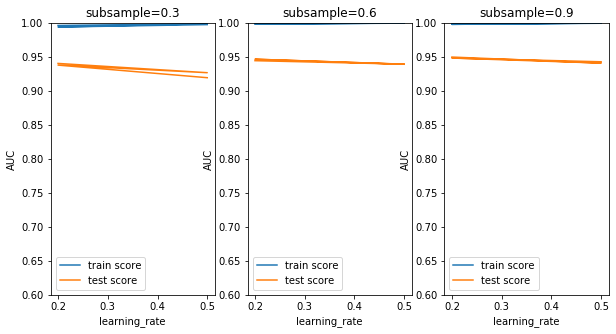

In [135]:
plt.figure(figsize= (10,5))

for i,subsample in enumerate(param_grid["subsample"]):
    
    plt.subplot(1,len(param_grid["subsample"]),i+1)
    df = cv_results[cv_results["param_subsample"]==subsample]
    
    plt.plot(df["param_learning_rate"],df["mean_train_score"])
    plt.plot(df["param_learning_rate"],df["mean_test_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['train score', 'test score'], loc='lower left')
    #plt.xscale('log')
        

In [136]:
cv_model.best_params_

{'gamma': 0, 'learning_rate': 0.2, 'subsample': 0.9}

In [140]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
mod_params = {'learning_rate': 0.2,
          'max_depth': 3, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = mod_params)
model.fit(X_train, y_train)

[02:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [141]:
#prediction
y_preds = model.predict(X_test)

y_preds_prob = model.predict_proba(X_test)

In [146]:
print("ROC AUC score",roc_auc_score(y_test,y_preds_prob[:,1]))

ROC AUC score 0.9720987736826276


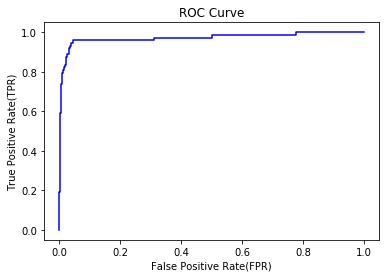

In [148]:
fpr,tpr,threshold = roc_curve(y_test,y_preds_prob[:,1])

plt.plot(fpr,tpr,color = "blue",label = "ROC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.show()

In [149]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29927
           1       0.63      0.23      0.34        73

    accuracy                           1.00     30000
   macro avg       0.81      0.62      0.67     30000
weighted avg       1.00      1.00      1.00     30000



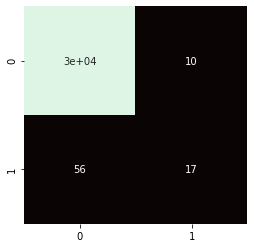

In [154]:
plt.figure(figsize= (4,4))
sns.heatmap(confusion_matrix(y_test,y_preds),
            annot = True,
            cmap = "mako",
            cbar = False)

In [155]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.05137798,
 'app': 0.16068555,
 'device': 0.19625731,
 'os': 0.074400604,
 'channel': 0.13146082,
 'day_of_week': 0.062767744,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.047558486,
 'ip_count': 0.078529276,
 'ip_day_hour': 0.04196379,
 'ip_hour_channel': 0.053365916,
 'ip_hour_os': 0.03770799,
 'ip_hour_app': 0.024730261,
 'ip_hour_device': 0.03919429}

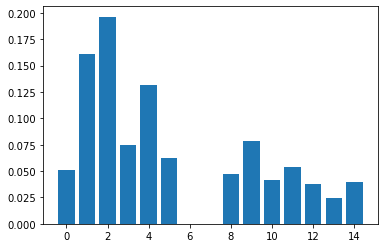

In [160]:
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
plt.show()